# Logistic Regression with Synthetic Minority Oversampling Technique

# POS and NEG

In [6]:
#import logging
import pandas as pd
import numpy as np
#from numpy import random
#import gensim
#import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE
import matplotlib.pyplot as plt
#from nltk.corpus import stopwords
#import re
from sklearn.metrics import classification_report
%matplotlib inline

df = pd.read_csv('cleaned-dataset.csv')
df = df[pd.notnull(df['mood'])]
df.head(10)

,mood,id,timestamp,no_query,username,tweet_text,is_duplicate
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting might cry r...,False
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many time ball managed save rest go bound,False
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feel itchy like fire,False
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving im mad cant see,False
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,whole crew,False
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug,False
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time see yes rain bit bit lol im fine...,False
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope didnt,False
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que muera,False
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break plain city snowing,False


In [7]:
X=df['tweet_text'].fillna(' ')
y=df['mood']

counts=y.value_counts()
print(counts)

0    749007
4    229997
Name: mood, dtype: int64


In [8]:
lr = LogisticRegression()

In [9]:
tv = TfidfVectorizer(stop_words=None, max_features=10000)
testing_tfidf = tv.fit_transform(X)

In [10]:
smt = SMOTE(random_state=777, k_neighbors=1)

X_SMOTE, y_SMOTE = smt.fit_sample(testing_tfidf, y)

In [11]:
y_SMOTE

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [12]:
unique, counts = np.unique(y_SMOTE, return_counts=True)
print(list(zip(unique, counts)))

[(0, 749007), (4, 749007)]


In [14]:
my_mood = ['positive','negative']

# K-fold and Evaluation metric

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfTransformer

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
accuracy = []
precision = []
recall = []
f1 = []
confusionMatrices=[]

lr = Pipeline([('tfidf', TfidfTransformer()),
               ('lr', LogisticRegression()),
              ])

for train, test in kfold.split(X_SMOTE, y_SMOTE):
    lr_fit = lr.fit(X_SMOTE[train], y_SMOTE[train])
    prediction = lr_fit.predict(X_SMOTE[test])
    #print(prediction)
    scores = lr_fit.score(X_SMOTE[test],y_SMOTE[test])
    accuracy.append(scores * 100)
    print(classification_report(y_SMOTE[test],prediction,target_names=my_mood))
    labels=my_mood
    for i in range(10):
        cm=confusion_matrix(y_SMOTE[test],prediction)
        confusionMatrices.append(cm)

print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

    positive       0.81      0.77      0.79    149802
    negative       0.78      0.81      0.80    149802

   micro avg       0.79      0.79      0.79    299604
   macro avg       0.79      0.79      0.79    299604
weighted avg       0.79      0.79      0.79    299604

              precision    recall  f1-score   support

    positive       0.80      0.77      0.78    149802
    negative       0.78      0.81      0.79    149802

   micro avg       0.79      0.79      0.79    299604
   macro avg       0.79      0.79      0.79    299604
weighted avg       0.79      0.79      0.79    299604

              precision    recall  f1-score   support

    positive       0.81      0.77      0.79    149801
    negative       0.78      0.82      0.80    149801

   micro avg       0.79      0.79      0.79    299602
   macro avg       0.79      0.79      0.79    299602
weighted avg       0.79      0.79      0.79    299602

              preci

# Confusion Matrix

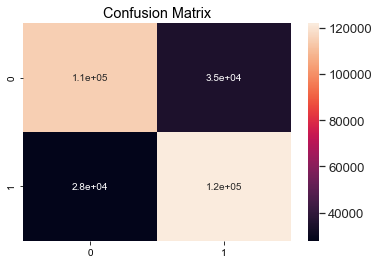

In [17]:
import seaborn as sn
labels=my_mood
matrix=confusionMatrices[0]
ax=plt.axes()
df_cm=pd.DataFrame(matrix,range(2),range(2))
sn.set(font_scale=1.2)#for Label size
sn.heatmap(df_cm,annot=True,annot_kws={"size":10})
ax.set_title('Confusion Matrix')
plt.show()

In [19]:
import pickle
pickle_out = open('./lr_fit_posneg.pkl', 'wb')
pickle.dump(lr_fit, pickle_out)
pickle_out.close()